<a href="https://colab.research.google.com/github/Nourjeday/ReCoDeWaste-Recyclable-vs-Non-Recyclable-Detection/blob/main/ReCoDeWaste_%E2%80%93_Recyclable_vs_Non%E2%80%91Recyclable_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup (Colab)

In [ ]:
# Check GPU
!nvidia-smi


# Install YOLOv8
!pip install -q ultralytics pycocotools opencv-python

Tue Dec 16 14:34:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Download ReCoDeWaste Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create YOLO Folder Structure

In [ ]:
import os

for split in ["train", "valid", "test"]:
    os.makedirs(f"/content/ReCoDeWaste/images/{split}", exist_ok=True)
    os.makedirs(f"/content/ReCoDeWaste/labels/{split}", exist_ok=True)

In [ ]:
BASE_PATH ="/content/drive/MyDrive/ReCoDeWaste/1. Instance Segmentation "

In [ ]:
import os

for split in ["train", "valid", "test"]:
    os.makedirs(f"/content/ReCoDeWaste/images/{split}", exist_ok=True)
    os.makedirs(f"/content/ReCoDeWaste/labels/{split}", exist_ok=True)


# COCO → YOLO Conversion (Binary Classes)

In [ ]:
import os
import shutil
from pycocotools.coco import COCO

RECYCLABLE_KEYWORDS = [
    "metal", "plastic", "wood", "cardboard", "paper", "glass", "timber"
]

def convert_split(split):
    ann_path = f"{BASE_PATH}/{split}/_annotations.coco.json"
    img_src = f"{BASE_PATH}/{split}/images"

    img_dst = f"/content/ReCoDeWaste/images/{split}"
    lbl_dst = f"/content/ReCoDeWaste/labels/{split}"

    coco = COCO(ann_path)

    missing_images = 0
    processed_images = 0

    for img_id in coco.getImgIds():
        img = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_src, img["file_name"])

        # 🔴 Skip if image file does not exist
        if not os.path.exists(img_path):
            missing_images += 1
            continue

        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))

        # copy image
        shutil.copy(img_path, os.path.join(img_dst, img["file_name"]))

        label_file = img["file_name"].rsplit(".", 1)[0] + ".txt"
        with open(os.path.join(lbl_dst, label_file), "w") as f:
            for ann in anns:
                x, y, w, h = ann["bbox"]
                xc = (x + w/2) / img["width"]
                yc = (y + h/2) / img["height"]
                wn = w / img["width"]
                hn = h / img["height"]

                cat_name = coco.loadCats(ann["category_id"])[0]["name"].lower()
                cls = 0 if any(k in cat_name for k in RECYCLABLE_KEYWORDS) else 1

                f.write(f"{cls} {xc} {yc} {wn} {hn}\n")

        processed_images += 1

    print(f"✅ {split}: {processed_images} images processed")
    print(f"⚠️ {split}: {missing_images} images skipped (filename mismatch)")


In [ ]:
for split in ["train", "valid", "test"]:
    convert_split(split)

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
✅ train: 0 images processed
⚠️ train: 1784 images skipped (filename mismatch)
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
✅ valid: 0 images processed
⚠️ valid: 500 images skipped (filename mismatch)
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
✅ test: 0 images processed
⚠️ test: 221 images skipped (filename mismatch)


In [ ]:
import os
train_images = os.listdir(BASE_PATH + "/train/images")
train_images[:20]

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ReCoDeWaste/1. Instance Segmentation /train/images'

In [ ]:
import os

def find_actual_image(img_name, image_dir):
    """
    img_name: from COCO annotation (e.g., mix01_rgb_0000.png)
    image_dir: path to train/images, valid/images, or test/images
    Returns the actual filename if found, else None
    """
    base = os.path.splitext(img_name)[0]  # remove extension
    for f in os.listdir(image_dir):
        if f.startswith(base):
            return f
    return None


In [ ]:
from pycocotools.coco import COCO
import shutil
import os

RECYCLABLE_KEYWORDS = ["metal", "plastic", "wood", "cardboard", "paper", "glass", "timber"]

def find_actual_image(img_name, image_dir):
    """Match COCO filename to actual file in folder"""
    base = os.path.splitext(img_name)[0]
    for f in os.listdir(image_dir):
        if f.startswith(base):
            return f
    return None

def convert_split(split):
    ann_path = f"{BASE_PATH}/{split}/_annotations.coco.json"
    img_src = f"{BASE_PATH}/{split}"  # ✅ use folder directly
    img_dst = f"/content/ReCoDeWaste/images/{split}"
    lbl_dst = f"/content/ReCoDeWaste/labels/{split}"

    coco = COCO(ann_path)

    missing_images = 0
    processed_images = 0

    for img_id in coco.getImgIds():
        img = coco.loadImgs(img_id)[0]
        actual_file = find_actual_image(img["file_name"], img_src)
        if actual_file is None:
            missing_images += 1
            continue

        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        shutil.copy(os.path.join(img_src, actual_file), os.path.join(img_dst, actual_file))

        label_file = actual_file.rsplit(".", 1)[0] + ".txt"
        with open(os.path.join(lbl_dst, label_file), "w") as f:
            for ann in anns:
                x, y, w, h = ann["bbox"]
                xc = (x + w/2) / img["width"]
                yc = (y + h/2) / img["height"]
                wn = w / img["width"]
                hn = h / img["height"]

                cat_name = coco.loadCats(ann["category_id"])[0]["name"].lower()
                cls = 0 if any(k in cat_name for k in RECYCLABLE_KEYWORDS) else 1

                f.write(f"{cls} {xc} {yc} {wn} {hn}\n")

        processed_images += 1

    print(f"✅ {split}: {processed_images} images processed")
    print(f"⚠️ {split}: {missing_images} images skipped")


In [ ]:
for split in ["train", "valid", "test"]:
    convert_split(split)


loading annotations into memory...
Done (t=10.23s)
creating index...
index created!
✅ train: 1784 images processed
⚠️ train: 0 images skipped
loading annotations into memory...
Done (t=4.04s)
creating index...
index created!
✅ valid: 500 images processed
⚠️ valid: 0 images skipped
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
✅ test: 221 images processed
⚠️ test: 0 images skipped


In [ ]:
import os

def build_image_lookup(split):
    img_dir = f"{BASE_PATH}/{split}"
    lookup = {}
    for f in os.listdir(img_dir):
        # remove everything after "_rf." and before the extension
        if "_rf." in f:
            base = f.split("_rf.")[0]
        else:
            base = os.path.splitext(f)[0]
        lookup[base] = f
    return lookup


In [ ]:
from pycocotools.coco import COCO
import shutil

RECYCLABLE_KEYWORDS = ["metal", "plastic", "wood", "cardboard", "paper", "glass", "timber"]

def convert_split(split):
    ann_path = f"{BASE_PATH}/{split}/_annotations.coco.json"
    img_src = f"{BASE_PATH}/{split}"
    img_dst = f"/content/ReCoDeWaste/images/{split}"
    lbl_dst = f"/content/ReCoDeWaste/labels/{split}"

    coco = COCO(ann_path)

    # build the lookup once
    img_lookup = build_image_lookup(split)

    missing_images = 0
    processed_images = 0

    for img_id in coco.getImgIds():
        img = coco.loadImgs(img_id)[0]
        # remove extension for JSON filename
        base_name = os.path.splitext(img["file_name"])[0]
        actual_file = img_lookup.get(base_name)

        if actual_file is None:
            missing_images += 1
            continue

        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        shutil.copy(os.path.join(img_src, actual_file), os.path.join(img_dst, actual_file))

        label_file = actual_file.rsplit(".", 1)[0] + ".txt"
        with open(os.path.join(lbl_dst, label_file), "w") as f:
            for ann in anns:
                x, y, w, h = ann["bbox"]
                xc = (x + w/2) / img["width"]
                yc = (y + h/2) / img["height"]
                wn = w / img["width"]
                hn = h / img["height"]

                cat_name = coco.loadCats(ann["category_id"])[0]["name"].lower()
                cls = 0 if any(k in cat_name for k in RECYCLABLE_KEYWORDS) else 1

                f.write(f"{cls} {xc} {yc} {wn} {hn}\n")

        processed_images += 1

    print(f"✅ {split}: {processed_images} images processed")
    print(f"⚠️ {split}: {missing_images} images skipped")


In [ ]:
for split in ["train", "valid", "test"]:
    convert_split(split)

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
✅ train: 1784 images processed
⚠️ train: 0 images skipped
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
✅ valid: 500 images processed
⚠️ valid: 0 images skipped
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
✅ test: 221 images processed
⚠️ test: 0 images skipped


In [ ]:
!ls /content/ReCoDeWaste/images/train | head
!ls /content/ReCoDeWaste/labels/train | head

mix01_rgb_0000_png_jpg.rf.b05d09eeb73e1cb168f62cf85e387251.jpg
mix01_rgb_0024_png_jpg.rf.e984af7c55bc08047f245a8ea4a84be7.jpg
mix01_rgb_0025_png_jpg.rf.0a649f78152049a35ff2c7b6f8d3464b.jpg
mix01_rgb_0026_png_jpg.rf.460743565f5289ba5f784abc1116cd81.jpg
mix01_rgb_0027_png_jpg.rf.d7cbe34d390e46e4b268d1d76fc042a1.jpg
mix01_rgb_0028_png_jpg.rf.4584de916de6b65b8938f3e65f453fc9.jpg
mix01_rgb_0029_png_jpg.rf.61940a1bb0e81e6dd81592d00439ce2d.jpg
mix01_rgb_0030_png_jpg.rf.2fb88f31692ac04ca985416ced9f5c0c.jpg
mix01_rgb_0031_png_jpg.rf.4fdc55efa87a1ede3434801792ae9896.jpg
mix01_rgb_0032_png_jpg.rf.dfb3984fae8d54388f26d9c2f0f04128.jpg
mix01_rgb_0000_png_jpg.rf.b05d09eeb73e1cb168f62cf85e387251.txt
mix01_rgb_0024_png_jpg.rf.e984af7c55bc08047f245a8ea4a84be7.txt
mix01_rgb_0025_png_jpg.rf.0a649f78152049a35ff2c7b6f8d3464b.txt
mix01_rgb_0026_png_jpg.rf.460743565f5289ba5f784abc1116cd81.txt
mix01_rgb_0027_png_jpg.rf.d7cbe34d390e46e4b268d1d76fc042a1.txt
mix01_rgb_0028_png_jpg.rf.4584de916de6b65b8938f3e65f453

In [ ]:
!pip install ultralytics

In [ ]:
# 1️⃣ Define YAML as a Python multi-line string
data_yaml = """
train: /content/ReCoDeWaste/images/train
val: /content/ReCoDeWaste/images/valid

nc: 2
names: ['recyclable', 'non_recyclable']
"""

# 2️⃣ Save it to a file
with open("/content/ReCoDeWaste.yaml", "w") as f:
    f.write(data_yaml)

print("✅ YAML file created at /content/ReCoDeWaste.yaml")


✅ YAML file created at /content/ReCoDeWaste.yaml


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="/content/ReCoDeWaste.yaml",  # ✅ path to YAML file
    imgsz=640,
    epochs=50,
    batch=16,
    project="ReCoDeWaste_YOLO",
    name="run1"
)


Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ReCoDeWaste.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b06cc4399a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
!ls "/content/drive/MyDrive/ReCoDeWaste/1. Instance Segmentation "

test  train  valid


In [ ]:
!ls /content/ReCoDeWaste_YOLO/

run1  run12


In [ ]:
!ls /content/ReCoDeWaste

images	labels


In [ ]:
!ls /content/ReCoDeWaste/images

test  train  valid


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/ReCoDeWaste_YOLO/run12/weights/best.pt")

model.predict(
    source="/content/ReCoDeWaste/images/test",
    conf=0.4,
    save=True
)


image 1/221 /content/ReCoDeWaste/images/test/mix08_rgb_0022_png_jpg.rf.2fc43cbcfa375ec7bd7151ff37229c6e.jpg: 384x640 29 recyclables, 28 non_recyclables, 57.9ms
image 2/221 /content/ReCoDeWaste/images/test/mix08_rgb_0034_png_jpg.rf.87ef77ba71fddb87ae1115b24f02c06e.jpg: 384x640 19 recyclables, 29 non_recyclables, 10.4ms
image 3/221 /content/ReCoDeWaste/images/test/mix08_rgb_0046_png_jpg.rf.2f05077426a6a0559e306f144d74974d.jpg: 384x640 26 recyclables, 39 non_recyclables, 8.9ms
image 4/221 /content/ReCoDeWaste/images/test/mix08_rgb_0058_png_jpg.rf.b56f8064da32820f7ce25dd9c7903a2d.jpg: 384x640 33 recyclables, 39 non_recyclables, 8.3ms
image 5/221 /content/ReCoDeWaste/images/test/mix08_rgb_0070_png_jpg.rf.7127bc6017de05346b2db46b49c85c14.jpg: 384x640 28 recyclables, 33 non_recyclables, 8.0ms
image 6/221 /content/ReCoDeWaste/images/test/mix08_rgb_0082_png_jpg.rf.639a3289fddd664e23ad243963da3f4c.jpg: 384x640 29 recyclables, 23 non_recyclables, 12.2ms
image 7/221 /content/ReCoDeWaste/images/te

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'recyclable', 1: 'non_recyclable'}
 obb: None
 orig_img: array([[[106, 114, 121],
         [105, 113, 120],
         [104, 112, 119],
         ...,
         [137, 136, 126],
         [138, 137, 127],
         [138, 137, 127]],
 
        [[104, 112, 119],
         [104, 112, 119],
         [105, 113, 120],
         ...,
         [138, 137, 127],
         [138, 137, 127],
         [138, 137, 127]],
 
        [[102, 110, 117],
         [104, 112, 119],
         [106, 114, 121],
         ...,
         [138, 137, 127],
         [139, 138, 128],
         [139, 138, 128]],
 
        ...,
 
        [[ 66,  58,  59],
         [ 65,  59,  60],
         [ 67,  59,  60],
         ...,
         [ 73,  67,  60],
         [ 73,  67,  60],
         [ 74,  68,  61]],
 
        [[ 67,  60,  63],
         [ 66,  61,  63],
         [ 67,  60,  63],
       

In [ ]:
!ls /content/ReCoDeWaste_YOLO/run12

args.yaml			 results.csv	      val_batch0_labels.jpg
BoxF1_curve.png			 results.png	      val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
BoxPR_curve.png			 train_batch1.jpg     val_batch1_pred.jpg
BoxR_curve.png			 train_batch2.jpg     val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch4480.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch4481.jpg  weights
labels.jpg			 train_batch4482.jpg


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/ReCoDeWaste_YOLO/run12/weights/best.pt")

model.predict(
    source="/content/ReCoDeWaste/images/test",
    conf=0.4,
    save=True
)


image 1/221 /content/ReCoDeWaste/images/test/mix08_rgb_0022_png_jpg.rf.2fc43cbcfa375ec7bd7151ff37229c6e.jpg: 384x640 29 recyclables, 28 non_recyclables, 8.5ms
image 2/221 /content/ReCoDeWaste/images/test/mix08_rgb_0034_png_jpg.rf.87ef77ba71fddb87ae1115b24f02c06e.jpg: 384x640 19 recyclables, 29 non_recyclables, 6.0ms
image 3/221 /content/ReCoDeWaste/images/test/mix08_rgb_0046_png_jpg.rf.2f05077426a6a0559e306f144d74974d.jpg: 384x640 26 recyclables, 39 non_recyclables, 5.8ms
image 4/221 /content/ReCoDeWaste/images/test/mix08_rgb_0058_png_jpg.rf.b56f8064da32820f7ce25dd9c7903a2d.jpg: 384x640 33 recyclables, 39 non_recyclables, 6.0ms
image 5/221 /content/ReCoDeWaste/images/test/mix08_rgb_0070_png_jpg.rf.7127bc6017de05346b2db46b49c85c14.jpg: 384x640 28 recyclables, 33 non_recyclables, 7.1ms
image 6/221 /content/ReCoDeWaste/images/test/mix08_rgb_0082_png_jpg.rf.639a3289fddd664e23ad243963da3f4c.jpg: 384x640 29 recyclables, 23 non_recyclables, 5.8ms
image 7/221 /content/ReCoDeWaste/images/test/

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'recyclable', 1: 'non_recyclable'}
 obb: None
 orig_img: array([[[106, 114, 121],
         [105, 113, 120],
         [104, 112, 119],
         ...,
         [137, 136, 126],
         [138, 137, 127],
         [138, 137, 127]],
 
        [[104, 112, 119],
         [104, 112, 119],
         [105, 113, 120],
         ...,
         [138, 137, 127],
         [138, 137, 127],
         [138, 137, 127]],
 
        [[102, 110, 117],
         [104, 112, 119],
         [106, 114, 121],
         ...,
         [138, 137, 127],
         [139, 138, 128],
         [139, 138, 128]],
 
        ...,
 
        [[ 66,  58,  59],
         [ 65,  59,  60],
         [ 67,  59,  60],
         ...,
         [ 73,  67,  60],
         [ 73,  67,  60],
         [ 74,  68,  61]],
 
        [[ 67,  60,  63],
         [ 66,  61,  63],
         [ 67,  60,  63],
       

In [ ]:
!ls /content/runs/detect/predict2

mix08_rgb_0022_png_jpg.rf.2fc43cbcfa375ec7bd7151ff37229c6e.jpg
mix08_rgb_0034_png_jpg.rf.87ef77ba71fddb87ae1115b24f02c06e.jpg
mix08_rgb_0046_png_jpg.rf.2f05077426a6a0559e306f144d74974d.jpg
mix08_rgb_0058_png_jpg.rf.b56f8064da32820f7ce25dd9c7903a2d.jpg
mix08_rgb_0070_png_jpg.rf.7127bc6017de05346b2db46b49c85c14.jpg
mix08_rgb_0082_png_jpg.rf.639a3289fddd664e23ad243963da3f4c.jpg
mix08_rgb_0094_png_jpg.rf.4269c3a71e6a3ae5822c84280dc3a4eb.jpg
mix08_rgb_0106_png_jpg.rf.42a41d3f5920fc595bb3262f8b66bd16.jpg
mix08_rgb_0111_png_jpg.rf.22e0647819d337179e2952a19fd3925f.jpg
mix08_rgb_0118_png_jpg.rf.99fe91c520c3df7f960d64bfb7627deb.jpg
mix08_rgb_0123_png_jpg.rf.285d3827cbabda953aab2dc14c106ea4.jpg
mix08_rgb_0130_png_jpg.rf.3434153c2de90d55a58e9fb8bcbd56d5.jpg
mix08_rgb_0135_png_jpg.rf.78a16428865d9221983ff60a8532151d.jpg
mix08_rgb_0142_png_jpg.rf.7a32b89aa4850395878d86e99d243978.jpg
mix08_rgb_0166_png_jpg.rf.fc1689a0854e13c79f21d055422a550c.jpg
mix08_rgb_0178_png_jpg.rf.af864f693cfe44205843b808926a1

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

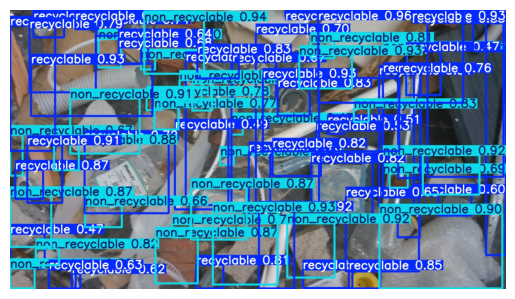

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/runs/detect/predict2/mix15_rgb_0419_png_jpg.rf.34de934faa26d45d4a8862147a14ac2a.jpg")
plt.imshow(img)
plt.axis("off")

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/ReCoDeWaste_YOLO/run12/weights/best.pt")

results = model.predict(
    source="/content/ReCoDeWaste/images/test",
    conf=0.4,
    save=False
)



image 1/221 /content/ReCoDeWaste/images/test/mix08_rgb_0022_png_jpg.rf.2fc43cbcfa375ec7bd7151ff37229c6e.jpg: 384x640 29 recyclables, 28 non_recyclables, 13.4ms
image 2/221 /content/ReCoDeWaste/images/test/mix08_rgb_0034_png_jpg.rf.87ef77ba71fddb87ae1115b24f02c06e.jpg: 384x640 19 recyclables, 29 non_recyclables, 8.2ms
image 3/221 /content/ReCoDeWaste/images/test/mix08_rgb_0046_png_jpg.rf.2f05077426a6a0559e306f144d74974d.jpg: 384x640 26 recyclables, 39 non_recyclables, 12.0ms
image 4/221 /content/ReCoDeWaste/images/test/mix08_rgb_0058_png_jpg.rf.b56f8064da32820f7ce25dd9c7903a2d.jpg: 384x640 33 recyclables, 39 non_recyclables, 10.0ms
image 5/221 /content/ReCoDeWaste/images/test/mix08_rgb_0070_png_jpg.rf.7127bc6017de05346b2db46b49c85c14.jpg: 384x640 28 recyclables, 33 non_recyclables, 9.0ms
image 6/221 /content/ReCoDeWaste/images/test/mix08_rgb_0082_png_jpg.rf.639a3289fddd664e23ad243963da3f4c.jpg: 384x640 29 recyclables, 23 non_recyclables, 9.6ms
image 7/221 /content/ReCoDeWaste/images/te

In [ ]:
def recyclability_score(result):
    boxes = result.boxes
    if boxes is None or len(boxes) == 0:
        return 0, "No waste detected"

    recyclable_score = 0.0
    total_score = 0.0

    for cls, conf in zip(boxes.cls, boxes.conf):
        total_score += conf.item()
        if int(cls.item()) == 0:  # recyclable
            recyclable_score += conf.item()

    percentage = (recyclable_score / total_score) * 100 if total_score > 0 else 0
    return round(percentage, 2), None

In [ ]:
for r in results:
    score, msg = recyclability_score(r)

    if msg:
        print("⚠️", msg)
    else:
        if score >= 70:
            phrase = f"♻️ This waste is {score}% recyclable"
        elif score >= 40:
            phrase = f" This waste is partially recyclable ({score}%)"
        else:
            phrase = f" This waste is mostly non-recyclable ({score}%)"

        print("Image:", r.path)
        print(phrase)
        print("-" * 50)


Image: /content/ReCoDeWaste/images/test/mix08_rgb_0022_png_jpg.rf.2fc43cbcfa375ec7bd7151ff37229c6e.jpg
 This waste is partially recyclable (47.41%)
--------------------------------------------------
Image: /content/ReCoDeWaste/images/test/mix08_rgb_0034_png_jpg.rf.87ef77ba71fddb87ae1115b24f02c06e.jpg
 This waste is mostly non-recyclable (39.16%)
--------------------------------------------------
Image: /content/ReCoDeWaste/images/test/mix08_rgb_0046_png_jpg.rf.2f05077426a6a0559e306f144d74974d.jpg
 This waste is mostly non-recyclable (39.32%)
--------------------------------------------------
Image: /content/ReCoDeWaste/images/test/mix08_rgb_0058_png_jpg.rf.b56f8064da32820f7ce25dd9c7903a2d.jpg
 This waste is partially recyclable (44.98%)
--------------------------------------------------
Image: /content/ReCoDeWaste/images/test/mix08_rgb_0070_png_jpg.rf.7127bc6017de05346b2db46b49c85c14.jpg
 This waste is partially recyclable (45.38%)
--------------------------------------------------
Ima

In [ ]:
import cv2

img = cv2.imread(r.path)
text = phrase

cv2.putText(
    img,
    text,
    (20, 40),
    cv2.FONT_HERSHEY_SIMPLEX,
    1,
    (0, 255, 0),
    2
)

cv2.imwrite("/content/recyclability_result.jpg", img)


True